In [6]:
#|export
%pip install -q numpy matplotlib opencv-python accelerate bitsandbytes scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [5]:
image_path = '../assets/diffuse.png'
mask_path = '../assets/mask.png'
real_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
image = cv2.imread(image_path)

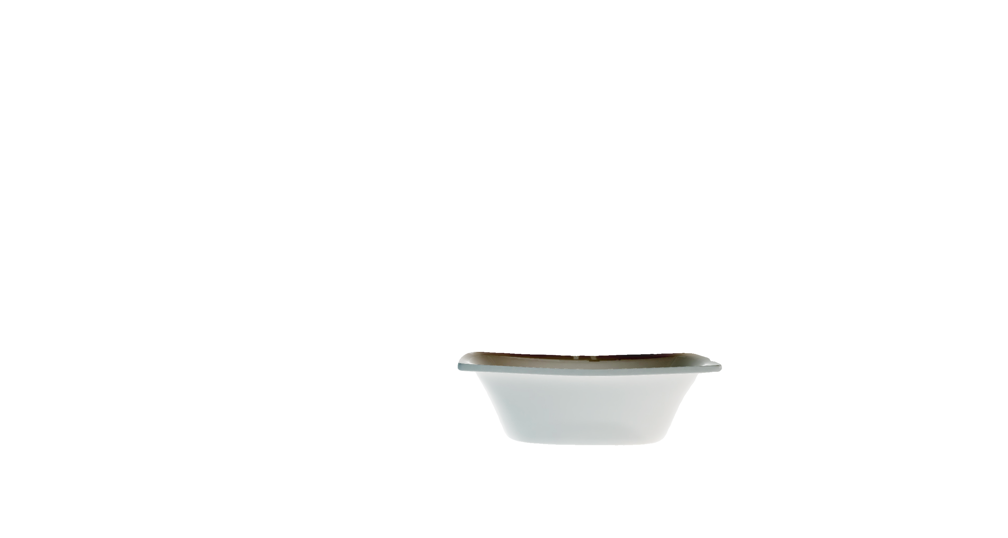

In [6]:
from PIL import Image

img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
width, height = im_pil.size
crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

if crop_mode == "wo_bg":
    masked_image = image * real_mask[:,:,np.newaxis] + (1 - real_mask[:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
else:
    masked_image = np.array(image)
masked_image = Image.fromarray(masked_image)

display(masked_image.resize((width // 3, height // 3)))

0.4540343915343915 0.34953703703703703 0.7159391534391535 0.44212962962962965


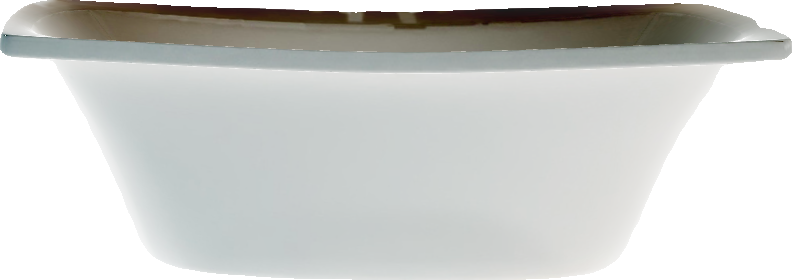

In [7]:
def boundary(inputs):
    col = inputs.shape[1]
    inputs = inputs.reshape(-1)
    lens = len(inputs)
    start = np.argmax(inputs)
    end = lens - 1 - np.argmax(np.flip(inputs))
    top = start // col
    bottom = end // col
    
    return top, bottom

def seg_to_box(seg_mask, size):
    top, bottom = boundary(seg_mask)
    left, right = boundary(seg_mask.T)
    left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

    return [left, top, right, bottom]

size = max(real_mask.shape[0], real_mask.shape[1])
left, top, right, bottom = seg_to_box(real_mask, size) # calculating the position of the top-left and bottom-right corners in the image
print(left, top, right, bottom)

image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
display(image_crop)

In [8]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if 'cuda' in device else torch.float32
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
captioning_model = Blip2ForConditionalGeneration.from_pretrained("../lib/blip/blip2-opt-2.7b/", torch_dtype=torch_dtype, local_files_only=True, load_in_8bit = False)



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 device = "cuda" if torch.cuda.is_available() else "cpu"                                      │
│   5 torch_dtype = torch.float16 if 'cuda' in device else torch.float32                           │
│   6 processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")                       │
│ ❱ 7 captioning_model = Blip2ForConditionalGeneration.from_pretrained("../lib/blip/", torch_d     │
│   8                                                                                              │
│   9                                                                                              │
│                                                                                                  │
│ /Users/antoinemacia/mambaforge/lib/python3.10/site-packages/transformers/modeling_utils.py:2269  │
│ in from_pretrained                                                                               │
│                                                                                                  │
│   2266 │   │   # Load config if we don't provide a configuration                                 │
│   2267 │   │   if not isinstance(config, PretrainedConfig):                                      │
│   2268 │   │   │   config_path = config if config is not None else pretrained_model_name_or_pat  │
│ ❱ 2269 │   │   │   config, model_kwargs = cls.config_class.from_pretrained(                      │
│   2270 │   │   │   │   config_path,                                                              │
│   2271 │   │   │   │   cache_dir=cache_dir,                                                      │
│   2272 │   │   │   │   return_unused_kwargs=True,                                                │
│                                                                                                  │
│ /Users/antoinemacia/mambaforge/lib/python3.10/site-packages/transformers/configuration_utils.py: │
│ 547 in from_pretrained                                                                           │
│                                                                                                  │
│   544 │   │   assert config.output_attentions == True                                            │
│   545 │   │   assert unused_kwargs == {"foo": False}                                             │
│   546 │   │   ```"""                                                                             │
│ ❱ 547 │   │   config_dict, kwargs = cls.get_config_dict(pretrained_model_name_or_path, **kwarg   │
│   548 │   │   if "model_type" in config_dict and hasattr(cls, "model_type") and config_dict["m   │
│   549 │   │   │   logger.warning(                                                                │
│   550 │   │   │   │   f"You are using a model of type {config_dict['model_type']} to instantia   │
│                                                                                                  │
│ /Users/antoinemacia/mambaforge/lib/python3.10/site-packages/transformers/configuration_utils.py: │
│ 574 in get_config_dict                                                                           │
│                                                                                                  │
│   571 │   │   """                                                                                │
│   572 │   │   original_kwargs = copy.deepcopy(kwargs)                                            │
│   573 │   │   # Get config dict associated with the base config file                             │
│ ❱ 574 │   │   config_dict, kwargs = cls._get_config_dict(pretrained_model_name_or_path, **kwar   │
│   575 │   │   if "_commit_hash" in config_dict:            

In [9]:
prompt = "Question: What Bathroom furniture is this? Answer:"

inputs = processor(image_crop, text=prompt, return_tensors = "pt").to(device, torch_dtype)
out = captioning_model.generate(**inputs, max_new_tokens = 20)
captions = processor.decode(out[0], skip_special_tokens = True).strip()

captions

'This is a bathtub'